# Temperature Control Lab, step identification

The [temperature control lab](https://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) or TCLab is a laboratory device used for thermal projects. It can be used to simulate and develop thermal control and regulation systems. The TCLab features a feedback control application with an Arduino, an LED, 2 heaters and 2 temperature sensors:  
- one heater will represent the TCS heating elements used for temperature control. 
- another will represent external disturbances such as solar radiation in the Cubesat application.

During this tutorial we will start using this card and carry out temperature measurements on control steps. The aim is to identify a dynamic model that can be used to synthesise the control.

### The TCLab Arduino Package

The Temperature Control Laboratory hardware consists of five components:

1. Arduino microcontroller board (Arduino Uno, Arduino Leonardo, or equivalents).

2. The Temperature Control Laboratory plug-in board (also known as a shield).

3. Five watt USB power supply.

4. 5.5mm to USB power supply cable.

5. USB 2.0 data cable. (w/mini-USB connector for Arduino Uno, or micro-USB cable for Arduino 
Leonardo.)

*TCLab kit:*
![TCLab](figures/B.00-arduino_lab_kit.png)

#### The main TCLab components
Thermistors: These are temperature sensors, there are two thermistors on a TCLab to measure at two different points.
The TCLab is equipped with 2 heaters to heat the system for temperature control experiments.
#### Assembly 
The TCLab is attached to the inputs of the arduino board (sort of metal teeth), then a blue cable connects the micro USB type B port on the arduino board to the USBA port on the PC. The TCLab is powered via the mains and its DC power port.
#### Setup
Before going further, be sure to complete the steps outlined under *Hardware setup* as described in TCLab [README](https://github.com/jckantor/TCLab/blob/master/README.rst). Mac OS users may need to install a serial driver available [here](https://github.com/adrianmihalko/ch340g-ch34g-ch34x-mac-os-x-driver). Normally the TCLab shield will already be mounted on the Arduino board, and the firmware driver will have been loaded on to the Arduino.



### Overall software architecture
The accompanying diagram shows how to access the temperature control laboratory using the TCLab library.

<img src='figures/B.00-TCLabOverview.png' style="float: right;padding-left:30px;"></img>

**_Jupyter notebooks and Python scripts:_**
The highest level consists of the you code you write to implement control algorithms. This can be done in Jupyter/Python notebooks, directly from Python using a development environment such as Spyder or PyCharm. This repository contains several examples, lessons, and student projects.

**_TCLab:_**
[TCLab](https://github.com/jckantor/TCLab) consists of a Python library entitled `tclab` that provides high-level access to sensors, heaters, a pseudo-realtime clock. The package includes `TCLab()` class that creates an object to access to the device, an iterator `clock` for synchronizing with a real time clock, `Historian()` class to create objects for data logging, and a `Plotter()` class to visualize data in realtime.

**_TCLab-sketch:_**
The [TCLab-sketch](https://github.com/jckantor/TCLab-sketch) github repository provides firmware to ensure intrisically safe operation of the Arduino board and shield. The sketch is downloaded to the Arduino using the [Arduino IDE](https://www.arduino.cc/en/Main/Software). Loading firmware to the Arduino is a one-time operation. 

**_Arduino:_**
The hardware platform for the Temperature Control Laboratory. The Python tools and libraries have been tested with the Arduino Uno and Arduino Leonardo boards.

### Getting to grips with the Arduino code

The Arduino sketch, when downloaded and installed on a compatible Arduino device, supports the Temperature Control Lab. The sketch is used in conjunction with the compatible Python library TCLab for programmable control of the Temperature Control Lab with Python via Python Serial library.

> Read the Arduino .ino code in C language from the file [here](https://github.com/jckantor/TCLab-sketch/blob/master/TCLab-sketch/TCLab-sketch.ino). Describe its structure and, in particular, its temporal execution. Copy below the part of the code that initalises the microntroleur at start-up, as well as the main loop.  

**Note:** For a better understanding, read the following page [Basic structure of an arduino code](https://arduinogetstarted.com/tutorials/arduino-code-structure)

:::{dropdown} Answers  
`setup()`: The setup function starts configurations with analogReference(EXTERNAL), then initializes serial communication using Serial.begin(baud) where baud is the communication speed. There is a while() that waits for serial communication to be established. This empty loop is necessary to ensure that the program doesn't try to communicate via the serial port until it's ready. 
The pinQ1 and pinQ2 outputs are initialized to a value of 0 using analogWrite, which initially switches off the 2 radiators. 

```
// arduino startup
void setup() {
  analogReference(EXTERNAL);
  Serial.begin(baud); 
  while (!Serial) {
    ; // wait for serial port to connect.
  }
  analogWrite(pinQ1, 0);
  analogWrite(pinQ2, 0);
}
```

`loop()`: This function is the main execution function and is executed in a loop, at each iteration of the loop it calls parseSerial() to analyze the data received via the serial port, then it calls dispatchCommand() to execute the commands. The checkTemp() function is written as a comment and is inactive.
 
``` 
// arduino main event loop
void loop() {
  parseSerial();
  dispatchCommand();
  //checkTemp();
}
```
:::

### Compiling and uploading code to an Arduino microcontroller

Complete the following steps:
- install Arduino software (if not done)
- if necessary upload the Tclab [TCLab-sketch.ino](https://github.com/jckantor/TCLab-sketch/blob/master/TCLab-sketch/TCLab-sketch.ino) code in the Arduino microcontroller (select the right Arduino card before with `Tools/Card` the right card type)
- select the communication port `Tools/Port`
- open the serial monitor `Tools/Serial Monitor`  


### Reading Temperatures with serial monitor

The temperature sensors on the temperature control lab can be acccessed with the attributes `T1` and `T2`.  
> In the serial monitor, send orders `T1` and `T2` what do you observe? Can you find the corresponding part of the code? 

:::{dropdown} Answers  

The `dispatchcommand()` function in the main execution loop executes commands (cmd) received over the serial link from the serial monitor or the python environment. 

```
void dispatchCommand(void) {
[...]
  else if (cmd == "T1") {
    sendFloatResponse(readTemperature(pinT1));
  }
[...]
  else if (cmd == "T2") {
    sendFloatResponse(readTemperature(pinT2));
  }
```

In our case, it executes commands T1 or T2 and calls the functions below: 
- Reading an analogue input with analogue-to-digital conversion and scaling. Averaging several acquisitions reduces sensitivity to measurement noise. 

``` 
// return average  of n reads of thermister temperature in °C
inline float readTemperature(int pin) {
  float degC = 0.0;
  for (int i = 0; i < n; i++) {
    degC += analogRead(pin) * 0.322265625 - 50.0;    // use for 3.3v AREF
    //degC += analogRead(pin) * 0.170898438 - 50.0;  // use for 1.75v AREF
  }
  return degC / float(n);
}
```

- The averaged value is sent via the serial link. 
```
void sendFloatResponse(float val) {
  Serial.println(String(val, 3));
}
```
:::

### Setting Heaters

Both heaters can be set between 0 to 100% power with the functions `Q1 x` ou `Q2 x` (where x is between 0 and 100). The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via
    
> Using the serial monitor, set source Q1 to 100% heat and observe the change in temperatures T1 and T2. What do you observe? **Stop all the heaters** with the `X` command.
 
    
**Note A:**  
1. The led on the temperature control laboratory will turns from dim to bright when either heater is on.
2. Closing the TCLab instance turns the heaters off.
3. The power level of the two heaters may be different. Current versions of the firmware limit maximum power of first heater to 4 watts, and maximum power of the second heater to 2 watts.
4. In addition to the constraints imposed by the firmware, the power supply may not be capable of providing all of the power needed to operate both heaters at 100%
5. The values retrieved from these functions may be different than the values set due to the power limits enforced by the device firmware.

**Note B:**
Each command returns a result string.

  A         software restart. Returns "Start".
  LED float set LED to float for 10 sec. range 0 to 100. Returns actual float
  P1 float  set pwm limit on heater 1, range 0 to 255. Default 200. Returns P1.
  P2 float  set pwm limit on heater 2, range 0 to 255. Default 100. Returns P2.
  Q1 float  set Heater 1, range 0 to 100. Returns value of Q1.
  Q2 float  set Heater 2, range 0 to 100. Returns value of Q2.
  Q1B float set Heater 1, range 0 to 100. Returns value of Q1 as a 32-bit float.
  Q2B float set Heater 2, range 0 to 100. Returns value of Q2 as a 32-bit float.
  R1        get value of Heater 1, range 0 to 100
  R2        get value of Heater 2, range 0 to 100
  SCAN      get values T1 T2 Q1 Q1 in line delimited values
  T1        get Temperature T1. Returns value of T1 in °C.
  T2        get Temperature T2. Returns value of T2 in °C.
  T1B       get Temperature T1. Returns value of T1 in °C as a 32-bit float.
  T2B       get Temperature T2. Returns value of T2 in °C as a 32-bit float.
  VER       get firmware version string
  X         stop, enter sleep mode. Returns "Stop"


### Getting to grips with the Arduino code

### Installing the tclab library

The TCLab package is installed from a terminal window (MacOS) or command window (PC) with the command

    pip install tclab

Alternatively, the installation can be performed from within a Jupyter/Python notebook with the command

    !pip install tclab

There are occasional updates to the library. These can be installed by appending a ` --upgrade` to the above commands and demonstrated in the next cell.

In [1]:
!pip install tclab --upgrade

  Using cached pyserial-3.5-py2.py3-none-any.whl (90 kB)


#### Creating a TCLab instance
    
Once installed, the `tclab` package can be imported into Python and an instance created with the Python statements

```
    from tclab import TCLab
    lab = TCLab()
    # do something
    lab.close()
```

TCLab() attempts to find a device connected to a serial port and return a connection. An error is generated if no device is found.  The connection must be closed when no longer in use.

**Note:** Before python use of the TCLab card, close the Arduino IDE Serial monitor. 

In [5]:
from tclab import TCLab

lab = TCLab()
lab.close()

TCLab version 1.0.0
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
TCLab disconnected successfully.


In [ ]:
.ino  # Il existe d'autres parties semblables à ce texte

void dispatchCommand(void) {
  // Heaters control Q1 or Q2
  if (cmd == "Q1") {
    Q1 = max(0.0, min(100.0, pv));
    iwrite = int(Q1 * 2.0); // 255 max
    iwrite = max(0, min(255, iwrite));    
    analogWrite(pinQ1, iwrite);
    Serial.println(Q1);
  }

    # Il existe d'autres parties semblables concernant la mesure de temperature
  else if (cmd == "Q2") {
    Q2 = max(0.0, min(100.0, pv));
    iwrite = int(Q2 * 1.0); // 255 max
    iwrite = max(0, min(255, iwrite));
    analogWrite(pinQ2, iwrite);
    Serial.println(Q2);
  } 

dispatchCommand: This function is called to process a command, and is designed to control radiators (Q1 and Q2).
 Q1 control: If the command received is "Q1", the code performs the following steps: Q1 is set equal to the current value of pv (a temperature value) limited between 0 and 100. The value of Q1 is then converted into a value suitable for the PWM (pulse width modulation) command used to control heating power. 
Here the value is multiplied by 2 and limited between 0 and 255 (the acceptable range for analogWrite which controls the PWM output). Finally, using the analogWrite function, the Q1 value is sent to the serial port. 
The rest of the code is similar for the Q2 command, the values are adjusted and we focus on the pinQ2 output.
The dispatchCommand function analyzes a received command and controls heating Q1 or Q2 according to the command received and the value of pv

> **Note :** dans ce projet nous allons utilisé une ancienne version logicielle de TCLab notemment au niveau du code .ino à télécharger sur le microcontroleur. Il est disponible sur Github [ici](https://github.com/APMonitor/arduino/tree/master/0_Test_Device/Python/tclab) et présente l'avantage d'être plus simple et facile à modifier que la version la plus récente.


## The Arduino board  
An Arduino board is an open-source electronic prototyping platform. 

### The main Arduino components
Microcontroller (MCU): This is the heart of the Arduino board, executing programs and controlling inputs/outputs. 
Input/Output (I/O) ports: These are the pins to which electronic components are connected. There are digital I/O pins (binary 1-0) and analog I/O pins (DC via 5V). 
Finally, we can add a reset button, LEDs and a USB port for communication with a computer (5V). Pins for connecting shields/other external components 

## summury & utility
the Arduino board is a versatile prototyping platform, while the TCLab is a specific device for controlling, collecting data and analyzing results
By combining the 2 boards, we can build a variety of models for developing controllers that can be adapted to the projects and applications we meet. For example, you can regulate, monitor and control the temperature of the TCLab as you wish. By setting threshold values, we can decide to heat up if necessary.

## Explication du code TCLab.py 

**The necessary modules are imported: time, numpy...

**A TCLab class is defined with a __init__ method, which initializes the serial connection with the Arduino, specifying the port and baud rate.

**The findPort() method is used to find the serial port to which the Arduino is connected.

**Once the serial connection has been established, self.sp.flushOutput() flushes the input and output buffers, then waits 3 seconds to allow the Arduino to initialize.

**Once the connection is complete, you'll get the message "TCLab connected via Arduino on port"

**def findPort(self) :
        found = False : This variable is initialized to False. It will be used to indicate whether a port corresponding to the Arduino has been found.

**The system has a list of serial ports with "for port in list(list_ports.comports()) :" it browses its list

example_ **"if port[2].startswith('USB VID:PID=2341:0043') :" is a condition that searches for a specific port designation

**port = port[0] : This assigns the first part of the port description to the port variable, which is usually the name of the port itself.
found = True: This indicates that the port corresponding to the Arduino has been found.

**The findPort method is designed to search for specific port descriptors corresponding to different types of Arduino, such as Arduino Uno, Arduino HDuino and Arduino Leonardo.  

**This part is very similar to the previous one, adding specific instructions for finding the Arduino's COM port. 
Depending on your system: Windows, MacOS, Linux, by manually specifying 

## Parallele with TCLab.ino code

### .ino program generalities 
The TCLab program we have consists of several parts. A part where variables and constants are shifted. A SETUP section used to initialize the program, i.e. configure inputs, start serial communication, etc. 
A LOOP section, executed after SETUP, containing all the lines needed to perform an action such as taking a temperature. It is in the LOOP that periodic and continuous actions are recorded, as it is read in a loop. 
Finally, the program contains comments, and library import is necessary at the start.

Common points and Differences :

 Both programs control radiators. The Python program uses Q1, Q2 and LED directly, whereas the Arduino program uses the dispatchCommand() function in response to 'Q1' and 'Q2' commands. Similarly, to read the temperatures (T1 and T2) we use dispatchCommand() with the arduino interface.

Both programs use serial communication to exchange data with the hardware. Python uses the serial module for serial communication, while the Arduino uses the Serial.begin() and Serial.println() functions for serial communication.
on python you can display information directly in the cell, while on the arduino you have to go through the serial monitor. 
 
Execution environment: The first program runs on the computer, while the second runs on an Arduino microcontroller.

**In the first program, initialization is performed in the constructor of the TCLab class. In the second program, initialization is performed in a separate function called setup().

In the Python program, the serial port is detected automatically using the serial.tools list_ports module, while in the Arduino program the port is specified manually.

Each program has features specific to its platform. For example, the Python program includes methods for saving data in a text file, while the Arduino program includes functions for checking temperatures above a certain limit.

stop(self): Sends a command to stop current operations on the device. version(self): Queries software version. 
@property def T1(self): Sends a command to read the temperature value, then converts this value into a float and stores it. 
@property def T2(self): Works similarly to T1
def LED(self, pwm): Sets and sends a PWM (pulse width modulation) value to control an LED
def Q1(self, pwm) and def Q2(self, pwm): Set and send PWM values to control 2 heaters Q1 and Q2. 
This code can be used to send commands to Arduino, read responses ... it's mainly used to control the radiators and monitor temperature.

In [ ]:
.ino

// check temperature and shut-off heaters if above high limit
void checkTemp(void) {
    float mV = (float) analogRead(pinT1) * (3300.0/1024.0);
    float degC = (mV - 500.0)/10.0;
    if (degC >= 100.0) {
      Q1 = 0.0;
      Q2 = 0.0;
      analogWrite(pinQ1, 0);
      analogWrite(pinQ2, 0);
      Serial.println("High Temp 1 (>100C): ");
      Serial.println(degC);

This checkTemp function monitors the temperature measured by a T1 sensor. This may be a safety measure to protect components. 
The function begins by measuring the voltage in millivolts (mV) using the analogRead() function. The measured voltage is then converted to °C using a formula (float) analogRead(pinT1) * (3300.0/1024. 0);which converts the voltage in millivolts into °C Assuming that the voltage of 500 mV corresponds to 0°C and that the temperature rises by 10°C for every 1 V increase in voltage, the formula used is (mV - 500.0) / 10.0. Temperature check: Next, the function checks whether the measured temperature is >= 100 °C If the temperature exceeds this threshold, the heaters (Q1 and Q2) are deactivated = 0.0. The heater control outputs (pinQ1 and pinQ2) are also set to 0 using analogWrite to stop the current. 

save_txt(self, t, u1, u2, y1, y2, sp1, sp2) : This method takes into account different data elements t: time u1 and u2: heating values y1 and y2: temperature values, sp1 and sp2: setpoint values It uses the NumPy library to manipulate data efficiently. Data are stacked vertically using np.vstack((t, u1, u2, y1, y2, sp1, sp2)) to form a data matrix, then transposed (data.T) to make them compatible with the np.savetxt() function. A top= string is defined to represent the column headers in the text file. Finally, the np.savetxt() function is used to save the data in a text file named "data.txt".
 To summarize this method saves the data supplied as parameters in a text file with the appropriate headers for each column, facilitating data analysis.

read(self, cmd) sends a command to the Arduino to read data, first constructing a command string, then attempting to write and read on the serial port, returning the decoded response. 
write(self, cmd, pwm) sends a command to the Arduino to write data, building a command string and sending it to the serial port, then returning the decoded response. 
build_cmd_str(self, cmd, args=None) builds a command string with possible arguments for the Arduino, and returns it. 
close(self) closes the connection with the Arduino by attempting to close the serial port and returning True. 
The aim is to establish and manage the connection, to send commands with or without arguments, and to read responses.

## Objectif 

For example, we're going to carry out tests/experiments to study the heat exchanges that will take place between the batteries and the envelope of a sat cube. 
We're working on a sat cube measuring 10x10x10 cm and weighing 1.3 Kg. We will assimilate certain satellite components to the 2 radiators. The batteries will be considered as the 1st radiator and the envelope as the 2nd. 
Our aim is to regulate the temperature so that the batteries work optimally, because they are constrained by temperature. For efficient operation, the temperature range must be maintained between 0 and 5 °C.To do this, we're going to study different situations: the case where the batteries are the only heat emitters, the case where they are inactive but the solar flux causes them to heat up, and finally the case where the batteries are used in addition to solar exposure (after 200s).

## Tests protocol  
** Radiators Q1 and Q2 don't have the same wattage/power, so test curves 1 and 2 will be different.

 ### Test_1
-Taking temperatures in 1 the battery and in 2 the envelope
-Heater Q1 heats up for 10 min
-Plot the following graph showing temperature (in °C) vs. time (in seconds). For T1 and T2 
-The graph also shows the percentage of Q1.
-Switch off Q1 after 10 min.
-Take final temperature in 1

 ### Test_2
-Taking temperatures in 1 (the battery) and in 2 the envelope
-Heater Q2 heats up for 10 min
-Plot the following graph showing temperature (in °C) vs. time (in seconds). For T1 and T2 
-The graph also shows the percentage of Q2.
-Switch off Q2 after 10 min.
-Take final temperature in 1

 ### Test_3
-Taking temperatures in 1 (the battery) and in 2 the envelope
-Heater Q1 heats up for 10 min
-Heater Q2 starts heating 200 seconds after Q1 and switches off at the same time as Q1 after 10 mins.
-Plot the following graph showing temperature (in °C) vs. time (in seconds). For T1 and T2 
-The graph also shows the percentage of Q2.
-Switch off Q1 & Q2.
-Take final temperature in 1

In [ ]:
#ESSAI 1 F

from tclab import TCLab, clock  # we import useful libraries, each time we call "import
                                                
lab = TCLab()              #TCLab enables initialization
lab.LED(100)             #clock is used to define the duration of a loop 

import time

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))


import matplotlib.pyplot as plt #allows you to enter data that will be used to draw curves
import numpy as np     #Allows you to perform calculations and represent data (Tabeleau,...).

time = []
Q1 = []                # These are the lists left empty by "plt".
T1 = []                # These are the lists left empty by "plt".
T2 = []

print("\nTurn Heater Q1 On")
lab.Q1(50)

tfinal = 600        # duration of test 
tstep = 1           # The measurement step, which also corresponds to the graph resolution

for t in clock(tfinal, tstep): # the clock loop is defined by these 2 time instructions
    print('+', end='') # For each measure/step the monitor will add the "+" character on the same line. 
    time = time + [t]         # We now fill the lists we left empty 
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]

    
import pandas as pd   # allows you to analyze and manipulate data for graph plotting
# Dataframe creation from lists where each column corresponds to one of these lists
df = pd.DataFrame([time, T1, T2, Q1]).T 
df.columns = ['Time', 'T1', 'T2', 'Q1'] 
df = df.set_index('Time') #to index time in the dataframe (trame de données)

# Dataframe display
df.plot(grid=True) #to create grids that make reading easier 

# Save as an excel or csv file
df.to_csv('Step_Test_Data_testing1.csv') 
print("\nTurn Heaters Off")
print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))
lab.Q1(0)

In [ ]:
#ESSAI 1 

from tclab import TCLab, clock
#from tclab import TCLab

lab = TCLab()
lab.LED(100)

import time

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))

In [ ]:
#ESSAI 1 F

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
T1 = []
T2 = []

print("\nTurn Heater Q1 On")
lab.Q1(50)

In [ ]:
#ESSAI 1 F

tfinal = 30
tstep = 1

for t in clock(tfinal, tstep):
    print('.', end='')
    time = time + [t]
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]

In [ ]:
#ESSAI 1 F
    
import pandas as pd
# Creation du dataframe
df = pd.DataFrame([time, T1, T2, Q1]).T
df.columns = ['Time', 'T1', 'T2', 'Q1']
df = df.set_index('Time')

# Affichage du dataframe
df.plot(grid=True)

# Enregistrement sous la forme d'un ficher excel ou csv
df.to_csv('Step_Test_Data.csv')
print("\nTurn Heaters Off")
lab.Q1(0)

In [ ]:
#ESSAI 2 F

from tclab import TCLab, clock  # we import useful libraries, each time we call "import
                                                
lab = TCLab()              #TCLab enables initialization
lab.LED(100)             #clock is used to define the duration of a loop 

import time

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))


import matplotlib.pyplot as plt #allows you to enter data that will be used to draw curves
import numpy as np     #Allows you to perform calculations and represent data (Tabeleau,...).

time = []
Q2 = []                # These are the lists left empty by "plt".
T1 = []                # These are the lists left empty by "plt".
T2 = []

print("\nTurn Heater Q1 On")
lab.Q2(50)

tfinal = 600        # duration of test 
tstep = 1           # The measurement step, which also corresponds to the graph resolution

for t in clock(tfinal, tstep): # the clock loop is defined by these 2 time instructions
    print('+', end='') # For each measure/step the monitor will add the "+" character on the same line. 
    time = time + [t]         # We now fill the lists we left empty 
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q2 = Q2 + [50]

    
import pandas as pd   # allows you to analyze and manipulate data for graph plotting
# Dataframe creation from lists where each column corresponds to one of these lists
df = pd.DataFrame([time, T1, T2, Q2]).T 
df.columns = ['Time', 'T1', 'T2', 'Q2'] 
df = df.set_index('Time') #to index time in the dataframe (trame de données)

# Dataframe display
df.plot(grid=True) #to create grids that make reading easier 

# Save as an excel or csv file
df.to_csv('Step_Test_Data_testing2.csv') 
print("\nTurn Heater Off")
print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))
lab.Q2(0)

TCLab version 1.0.0
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.

Starting Temperature 1: 23.38 °C
Starting Temperature 2: 22.93 °C

Turn Heaters Q1 On

Turn Heaters Q2 On after 200 seconds
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Turn Heaters Off

Final Temperature 1: 23.48 °C


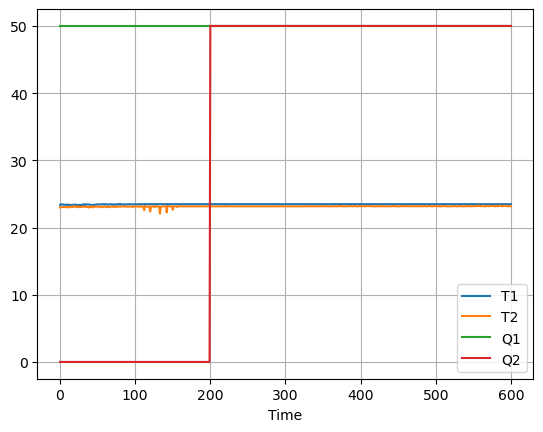

In [1]:
#ESSAI 3 F

from tclab import TCLab, clock  # we import useful libraries, each time we call "import
                  #clock is used to define the duration of a loop 
lab = TCLab()     #TCLab enables initialization
lab.LED(100)


import time
import pandas as pd

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))


import matplotlib.pyplot as plt   #allows you to enter data that will be used to draw curves
import numpy as np      #Allows you to perform calculations and represent data.

time = []  
Q1 = []
Q2 = []         # __= [] These are the lists left empty by "plt"
T1 = []
T2 = []

print("\nTurn Heaters Q1 On")
print("\nTurn Heaters Q2 On after 200 seconds")
lab.Q1(50)

tfinal = 600   # duration of test 
tstep = 1      # The measurement step, which also corresponds to the graph resolution

for t in clock(tfinal, tstep): # the clock loop is defined by these 2 time instructions
    print('.', end='') # For each measure/step the monitor will add the "." character on the same line. 
    time = time + [t]  # We now fill the lists we left empty 
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]
    if t >= 200:       # Time condition for engage Q2 
        lab.Q2(50)
        Q2 = Q2 + [50]  
    else:              # We now fill the lists we left empty, "else:" because Q2 can be in 2 states
        Q2 = Q2 + [0]
    

print("\nTurn Heaters Off")
lab.Q1(0)
lab.Q2(0)
lab.LED(0)

import pandas as pd # allows you to analyze and manipulate data for graph plotting
# Dataframe creation from lists where each column corresponds to one of these lists
df = pd.DataFrame([time, T1, T2, Q1, Q2]).T
df.columns = ['Time', 'T1', 'T2', 'Q1', 'Q2']
df = df.set_index('Time') #to index time in the dataframe (trame de données)

# Dataframe display
df.plot(grid=True) #to create grids that make reading easier

# Save as an excel or csv file
df.to_csv('Step_Test_Data_testing3.csv')
print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))

In [ ]:
#ESSAI 3 F

from tclab import TCLab, clock
#from tclab import TCLab

lab = TCLab()
lab.LED(100)
#lab.close()

In [ ]:
#ESSAI 3 F

import time
import pandas as pd

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))


import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
Q2 = []
T1 = []
T2 = []

In [ ]:
#ESSAI 3 F

print("\nTurn Heaters Q1 On")
print("\nTurn Heaters Q2 On after 200 seconds")
lab.Q1(50)

tfinal = 600
tstep = 1

for t in clock(tfinal, tstep):
    print('.', end='')
    time = time + [t]
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]
    if t >= 200:
        lab.Q2(50)
        Q2 = Q2 + [50]
    else:
        Q2 = Q2 + [0]
    

print("\nTurn Heaters Off")
lab.Q1(0)
lab.Q2(0)
lab.LED(0)

In [ ]:
#ESSAI 3 F

import pandas as pd
# Creation du dataframe
df = pd.DataFrame([time, T1, T2, Q1, Q2]).T
df.columns = ['Time', 'T1', 'T2', 'Q1', 'Q2']
df = df.set_index('Time')

# Affichage du dataframe
df.plot(grid=True)

# Enregistrement sous la forme d'un ficher excel ou csv
df.to_csv('Step_Test_Data.csv')

print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))

*La carte Arduino et le shield TCLab peut être acheté chez [Amazon](https://www.amazon.com/TCLab-Temperature-Control-Lab/dp/B07GMFWMRY).* 

## Illustration 

In [ ]:
import sys
import time
import numpy as np
try:
    import serial
except:
    import pip
    pip.main(['install','pyserial'])
    import serial
from serial.tools import list_ports
        
class TCLab(object):

    def __init__(self, port=None, baud=9600):
        port = self.findPort()
        print('Opening connection')
        self.sp = serial.Serial(port=port, baudrate=baud, timeout=2)
        self.sp.flushInput()
        self.sp.flushOutput()
        time.sleep(3)
        print('TCLab connected via Arduino on port ' + port)
        
    def findPort(self):
        found = False
        for port in list(list_ports.comports()):
            # Arduino Uno
            if port[2].startswith('USB VID:PID=2341:0043'):
                port = port[0]
                found = True
            # Arduino HDuino
            if port[2].startswith('USB VID:PID=1A86:7523'):
                port = port[0]
                found = True                
            # Arduino Leonardo
            if port[2].startswith('USB VID:PID=2341:8036'):
                port = port[0]
                found = True
        if (not found):
            print('Arduino COM port not found')
            print('Please ensure that the USB cable is connected')
            print('--- Printing Serial Ports ---')            
            for port in list(serial.tools.list_ports.comports()):
                print(port[0] + ' ' + port[1] + ' ' + port[2])
            print('For Windows:')
            print('  Open device manager, select "Ports (COM & LPT)"')
            print('  Look for COM port of Arduino such as COM4')
            print('For MacOS:')
            print('  Open terminal and type: ls /dev/*.')
            print('  Search for /dev/tty.usbmodem* or /dev/tty.usbserial*. The port number is *.')
            print('For Linux')
            print('  Open terminal and type: ls /dev/tty*')
            print('  Search for /dev/ttyUSB* or /dev/ttyACM*. The port number is *.')
            print('')
            port = input('Input port: ')
            # or hard-code it here
            #port = 'COM3' # for Windows
            #port = '/dev/tty.wchusbserial1410' # for MacOS
        return port
    
    def stop(self):
        return self.read('X')
    
    def version(self):
        return self.read('VER')
    
    @property
    def T1(self):
        self._T1 = float(self.read('T1'))
        return self._T1
    
    @property
    def T2(self):
        self._T2 = float(self.read('T2'))
        return self._T2
        
    def LED(self,pwm):
        pwm = max(0.0,min(100.0,pwm))/2.0
        self.write('LED',pwm)
        return pwm

    def Q1(self,pwm):
        pwm = max(0.0,min(100.0,pwm)) 
        self.write('Q1',pwm)
        return pwm
        
    def Q2(self,pwm):
        pwm = max(0.0,min(100.0,pwm)) 
        self.write('Q2',pwm)
        return pwm

    # save txt file with data and set point
    # t = time
    # u1,u2 = heaters
    # y1,y2 = tempeatures
    # sp1,sp2 = setpoints
    def save_txt(self,t,u1,u2,y1,y2,sp1,sp2):
        data = np.vstack((t,u1,u2,y1,y2,sp1,sp2))  # vertical stack
        data = data.T                 # transpose data
        top = 'Time (sec), Heater 1 (%), Heater 2 (%), ' \
          + 'Temperature 1 (degC), Temperature 2 (degC), ' \
          + 'Set Point 1 (degC), Set Point 2 (degC)' 
        np.savetxt('data.txt',data,delimiter=',',header=top,comments='')

    def read(self,cmd):
        cmd_str = self.build_cmd_str(cmd,'')
        try:
            self.sp.write(cmd_str.encode())
            self.sp.flush()
        except Exception:
            return None
        return self.sp.readline().decode('UTF-8').replace("\r\n", "")
    
    def write(self,cmd,pwm):       
        cmd_str = self.build_cmd_str(cmd,(pwm,))
        try:
            self.sp.write(cmd_str.encode())
            self.sp.flush()
        except:
            return None
        return self.sp.readline().decode('UTF-8').replace("\r\n", "")
    
    def build_cmd_str(self,cmd, args=None):
        """
        Build a command string that can be sent to the arduino.
    
        Input:
            cmd (str): the command to send to the arduino, must not
                contain a % character
            args (iterable): the arguments to send to the command
        """
        if args:
            args = ' '.join(map(str, args))
        else:
            args = ''
        return "{cmd} {args}\n".format(cmd=cmd, args=args)
        
    def close(self):
        try:
            self.sp.close()
            print('Arduino disconnected successfully')
        except:
            print('Problems disconnecting from Arduino.')
            print('Please unplug and reconnect Arduino.')
        return True
    

## References 

[Kantor, 2021] Kantor, JC., Chemical Process Control class materials [Link](https://jckantor.github.io/cbe30338-2021/) [github](https://github.com/jckantor/cbe30338-2021)